# **Modelling Loan Defaults**

## Objectives

* Fit and evaluate a classification model to predict if a borrower will default or not

## Inputs

* outputs/datasets/collection/LoanDefaultData.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Imports

In [1]:
import os

import pandas as pd
import numpy as np
# for vs code
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ML Performance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, make_scorer, f1_score

import joblib

# Ignore FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

---

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Step 1: Load Data

Load the data from the “collection” folder, since we want to design the pipeline to be able to handle the cleaning and engineering by itself.

In [4]:
df = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")

print(df.shape)
df.head(3)

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


### Drop duplicates

In [5]:
df = df.drop_duplicates()
print(df.shape)

(32416, 12)


### Set target variable

In [6]:
target_var = "loan_status"

---

# Step 2: ML Pipeline with all features

1. First create ML Pipelines:
    * the first three for cleaning and feature engineering 
    * the fourth for modelling using all available data to predict a borrowers's default. We won’t use this pipeline until a later stage in our notebook, but it’s good practice to create all your pipelines at the start of your notebook

2. Next, we split the data into train and test sets

3. After that, we can handle the target imbalance, by applying the cleaning and feature engineering pipelines to the data and then resampling the train set target

4. Once the data is ready, we fit the modelling pipeline we created using multiple algorithms while using their default hyperparameters, so we can find the algorithms that show the best fit for our data

5. Next, for these best given algorithm, we do an extensive optimization search so we can find the best hyperparameters for this algorithm and can identify the best model

6. After that we’ll need to assess the best model's most relevant features from the second pipeline

7. And finally, we evaluate the pipeline using the best model on the train and test sets to check if it meets the requirements we set in our business case

## ML pipeline for Data Cleaning and Feature Engineering

First we apply what we know from the previous feature engineering step.

In [7]:
def PipelineDataCleaningAndFeatureEngineeringPart1():
    pipeline_base = Pipeline([
        ("MedianImputer", MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', fold=5, tail='right', 
                                  variables=['person_age','person_income', 'person_emp_length',
                                             'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                                             'cb_person_cred_hist_length'])),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalEncoderArbitrary", OrdinalEncoder(encoding_method='arbitrary', 
                                                   variables=['person_home_ownership', 
                                                              'loan_intent', 
                                                              'cb_person_default_on_file'], 
                                                   unseen='encode'))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart1()

Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person_age', 'person_income',
                                           'cb_person_cred_hist_length'])),
                ('power_transform',
                 PowerTransformer(variables=['person_emp_length', 'loan_amnt',
                                             'loan_percent_income'])),
                ('OrdinalEncoderArbitrary',
                 OrdinalEncoder(encoding_method='arbitrary', unseen='encode',
                                variables=['person_home_ownership',
                                           'loan_intent',
                                           'cb_person_default_on_file']))])

The categorical encoder for `loan_grade` has to be directly applied on the `loan_grade` column and therefore has to be applied seperately from the other feature engineering steps.

In [8]:
def PipelineDataCleaningAndFeatureEngineeringPart2():
    pipeline_base = Pipeline([
        ("OrdinalEncoderOrdered", OrdinalEncoder(encoding_method='ordered', variables="loan_grade", unseen='encode'))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart2()

Pipeline(steps=[('OrdinalEncoderOrdered',
                 OrdinalEncoder(unseen='encode', variables='loan_grade'))])

After all the previous transformations we still need to apply SmartCorrelatedSelection

In [ ]:
def PipelineDataCleaningAndFeatureEngineeringPart3():
    pipeline_base = Pipeline([
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance"))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineeringPart3()

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [ ]:
%pip install catboost

In [10]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

## Split Train and Test Set

At this point, we use all 11 features.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_var], axis=1),
    df[target_var],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 11) (25932,) (6484, 11) (6484,)


In [12]:
X_train.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10594,25,35364,RENT,0.0,EDUCATION,A,10000,9.32,0.28,N,3
7088,22,60000,RENT,3.0,EDUCATION,A,7000,6.91,0.12,N,2
14601,26,45600,RENT,5.0,VENTURE,A,2000,NaN,0.04,N,3


## Handle Target Imbalance

From our previous analysis we know we have to handle target imbalance to improve performance.

### Preparation: Data Cleaning and Feature Engineering

First apply PipelineDataCleaningAndFeatureEngineeringPart1(), PipelineDataCleaningAndFeatureEngineeringPart2() and PipelineDataCleaningAndFeatureEngineeringPart3(), because for resampling, the data can’t contain missing values
or categorical values. 

In [13]:
pipeline_data_cleaning_feat_eng_part1 = PipelineDataCleaningAndFeatureEngineeringPart1()
X_train = pipeline_data_cleaning_feat_eng_part1.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng_part1.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 11) (25932,) (6484, 11) (6484,)


In [14]:
pipeline_data_cleaning_feat_eng_part2 = PipelineDataCleaningAndFeatureEngineeringPart2()
X_train["loan_grade"] = pipeline_data_cleaning_feat_eng_part2.fit_transform(X_train[["loan_grade"]],y_train)
X_test["loan_grade"] = pipeline_data_cleaning_feat_eng_part2.transform(X_test[["loan_grade"]])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 11) (25932,) (6484, 11) (6484,)


In [15]:
pipeline_data_cleaning_feat_eng_part3 = PipelineDataCleaningAndFeatureEngineeringPart3()
X_train = pipeline_data_cleaning_feat_eng_part3.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng_part3.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 8) (25932,) (6484, 8) (6484,)


After applying the data cleaning and feature engineering pipeline, the number of features decreased from 11 to 8, because of ``SmartCorrelatedSelection``.

#### Apply SMOTE

Check current Train Set Target distribution to confirm the target is currently imbalanced.

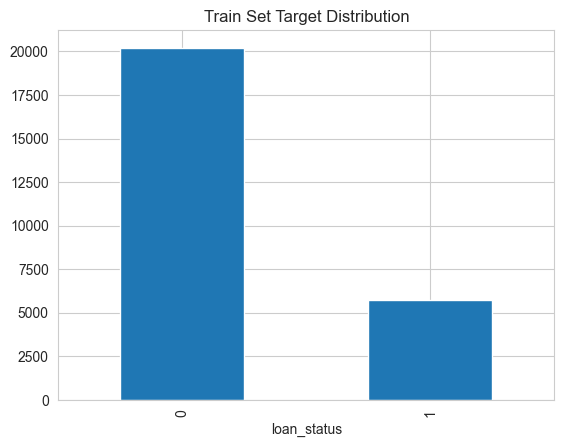

In [16]:
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling Technique) to balance the Train Set target.

In [17]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40418, 8) (40418,) (6484, 8) (6484,)


Check Train Set Target distribution after resampling and confirm that the target is now balanced.

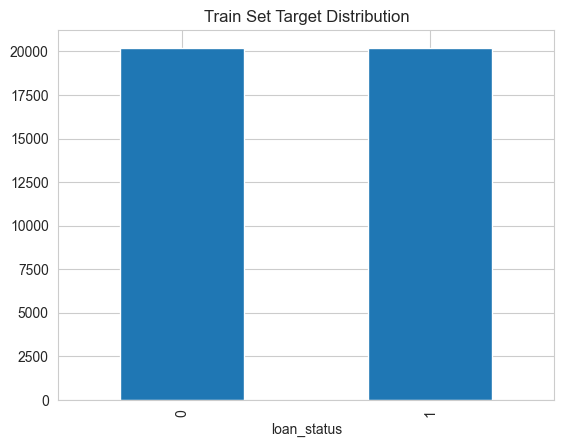

In [18]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

This step is divided into 2 subsections:
* First, we will fit a set of pipelines for each algorithm using the default hyperparameters,
to find the algorithm that most suits the data
* Then, we will do an extensive hyperparameter search using this algorithm

This combined approach is faster than doing one extensive search on all algorithms at once.

### Custom Class for Hyperparameter Optimisation

We use the custom class introduced by Code Institute in the "Churnometer" walkthrough project to assist with hyperparameter optimization. We customized the class to support both RandomizedSearchCV and GridSearchCV. The RandomizedSearchCV option was added to reduce computation time during the extensive hyperparameter search.

The class automates the hyperparameter tuning process across multiple models, each with its own parameter grid.

In the fit() method, each model is wrapped in a custom PipelineClf() and passed to GridSearchCV/RandomizedSearchCV, which performs an exhaustive search over the defined hyperparameter combinations using cross-validation. The fitted grid search objects are stored for later analysis.

The score_summary() method then compiles the cross-validation results into a unified DataFrame, summarizing each model’s minimum, maximum, mean, and standard deviation of scores, enabling quick and consistent comparison across all tested algorithms.

In [19]:
# Source: Code Institute, Churnometer Walkthrough Project
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, n_iter=30, randomized=False, verbose=1, scoring=None, refit=False):
        
        for key in self.keys:

            model = PipelineClf(self.models[key])
            params = self.params[key]
            if randomized == True:
                print(f"\nRunning RandomizedSearchCV for {key} \n")
                gs = RandomizedSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                                verbose=verbose, scoring=scoring, n_iter=n_iter)
            else: 
                print(f"\nRunning GridSearchCV for {key} \n")
                gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                                  verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Custom Performance Metric

To evaluate model performance we use a hybrid score combining recall and F1 because the target is imbalanced and catching defaults is critical. This ensures the model prioritizes identifying true defaults (high recall) while still considering overall predictive quality (F1), guiding hyperparameter tuning toward a practical, business-relevant performance.

In [20]:
def hybrid_score(y_true, y_pred):
    return 0.7 * recall_score(y_true, y_pred, pos_label=1) + 0.3 * f1_score(y_true, y_pred, average='macro')

### Use standard hyperparameters to find most suitable algorithms

#### Define algorithms for Quick Search

In [21]:
models_quick_search = {
    # Linear models
    "LogisticRegression": LogisticRegression(random_state=0),
    "RidgeClassifier": RidgeClassifier(random_state=0),

    #Tree-based models
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),

    # Boosting methods 
    "XGBClassifier": XGBClassifier(random_state=0),
    "CatBoostClassifier": CatBoostClassifier(random_state=0, verbose=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0)
}

# Set empty dictionaries to indicated that we use the default hyperparameters
params_quick_search = {
    "LogisticRegression": {},
    "RidgeClassifier": {},
    "XGBClassifier": {},
    "CatBoostClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


For our binary classification task, we select a diverse set of models that cover different algorithmic families and learning principles. This allows us to compare performance across linear, tree-based, and ensemble approaches:

* Linear Models:  
Serve as strong and interpretable baselines. They model linear relationships between features and the target and provide useful insights into feature importance.

* Tree-Based Models:  
Capture nonlinear relationships and feature interactions without requiring scaling or transformation. Random Forest and Extra Trees improve generalization by aggregating multiple decision trees.

* Boosting Methods:  
Build powerful ensembles by sequentially improving weak learners. These algorithms often achieve high accuracy on structured data and handle complex feature relationships effectively.

This model mix ensures a comprehensive benchmark, from simple and interpretable models to complex and high-performing ensemble methods, helping us identify the most suitable approach for our dataset.

#### Quick GridSearch CV

Now, we perform a quick GridSearchCV to evaluate the model performance of the different algorithms using the default hyperparameters.

We use 5-fold cross-validation to obtain a robust estimate of model performance and reduce the impact of random variation in the training data. It is a rule of thumb used in data science as a starting point.

In [24]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RidgeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard\.venv\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimato


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for CatBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


#### Check results

In [25]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.784036,0.847187,0.869415,0.032793
2,DecisionTreeClassifier,0.750702,0.831549,0.859673,0.041608
1,RidgeClassifier,0.756409,0.80844,0.832979,0.027197
0,LogisticRegression,0.743691,0.797929,0.820852,0.028015
8,GradientBoostingClassifier,0.617492,0.792094,0.856146,0.089239
6,CatBoostClassifier,0.102471,0.722107,0.965618,0.336969
5,XGBClassifier,0.1,0.649264,0.869458,0.301792
7,AdaBoostClassifier,0.140286,0.620017,0.778271,0.245742
4,ExtraTreesClassifier,0.802971,NaN,0.860966,NaN


* Among the tested algorithms, the best-performing model is the ``RandomForestClassifier``, achieving a mean Recall score of 0.847. The second-best model is the ``DecisionTreeClassifier``, with a Recall score of 0.832.

In a professional setting, we could continue tuning hyperparameters for both models, as their scores are both high and offer strong potential. However, to reduce computing time while still meeting the project requirements defined by Code Institute, we will focus only on the ``RandomForestClassifier`` for the next steps.

### Do an extensive search on the RandomForestClassifier to find the best hyperparameter configuration

Now we will perform an extensive grid search using the RandomForestClassifier to optimize its hyperparameters for the best possible performance.

#### Define algorithm and hyperparameters for Extensive Search

In [ ]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier(random_state=0)
}

# Documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://www.geeksforgeeks.org/machine-learning/hyperparameters-of-random-forest-classifier/
   
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [500, 800, 1000],  
        'model__criterion': ["gini", "log_loss", "entropy"],      
        'model__max_depth': [6, 8, 10],           
        'model__min_samples_split': [2, 5, 10],         
        'model__min_samples_leaf': [1, 3, 5],           
        'model__max_features': ["sqrt", "log2", 0.5],   
        'model__class_weight': ['balanced', None]       
    }
}

#### Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score),
           n_jobs=-1, cv=5, randomized=True, n_iter=50) # use RandomizedSearchCV to reduce computing time


Running RandomizedSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### Check results

In [25]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__criterion,model__class_weight
33,RandomForestClassifier,0.787042,0.807317,0.820064,0.011472,1000,5,3,sqrt,6,gini,None
1,RandomForestClassifier,0.786226,0.807297,0.820965,0.011957,1000,10,1,log2,6,gini,None
45,RandomForestClassifier,0.786189,0.807141,0.820507,0.011819,1000,10,3,log2,6,gini,None
5,RandomForestClassifier,0.786374,0.807138,0.819457,0.011437,1000,5,1,0.5,6,gini,None
16,RandomForestClassifier,0.786674,0.80712,0.819929,0.011554,800,2,3,0.5,6,gini,None


Get best model name programmatically

In [26]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

The best RandomForestClassifier model has a mean score of 0.8 and the following hyperparameters:

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__n_estimators': 1000,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 3,
 'model__max_features': 'sqrt',
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__class_weight': None}

Extract the best classification pipeline from the GridSearchCV object, which includes the preprocessing steps and the model fitted with the optimal hyperparameters found during the grid search.

In [28]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=1000,
                                        random_state=0))])

## Assess feature importance

Our classification pipeline consists of three steps:

1. Feature scaling – standardizes the numerical variables.
2. Feature selection – selects the most relevant features for the model.
3. Modelling – fits the RandomForestClassifier on the selected features.

We can extract two pieces of information from the pipeline:

* Selected features: which features passed through the feature selection step and are actually used by the model.
* Feature importance: the importance scores of these features as calculated by the Random Forest in the modelling step.

In [29]:
selected_features = X_train.columns[pipeline_clf['feat_selection'].get_support()]
print(f"Number of selected features: {len(selected_features)}")
selected_features


Number of selected features: 3


Index(['person_income', 'loan_amnt', 'loan_int_rate'], dtype='object')

In [51]:
print("Feature importance:")
pipeline_clf['model'].feature_importances_

Feature importance:


array([0.47080313, 0.3834102 , 0.14578667])

We create a DataFrame that contains these features' importance and plot it as a bar plot, to show the most important features for the model.

* These are the 3 most important features in descending order. The model was trained on them: 
['person_income', 'loan_int_rate', 'loan_amnt']


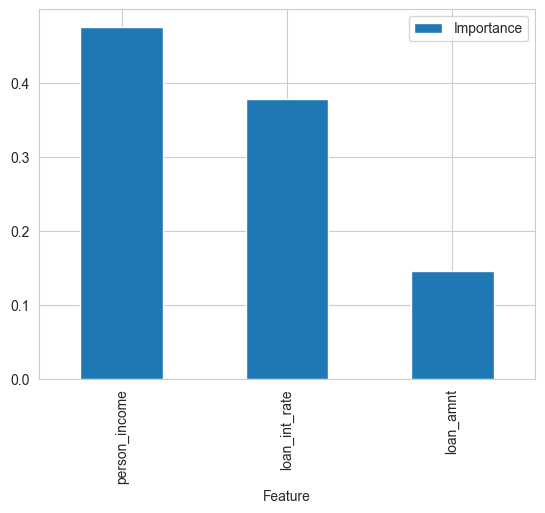

In [ ]:
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


From the feature importance analysis, only three features show substantial predictive power for loan default:

* ``person_income``: The most influential feature. Borrowers’ income strongly affects the model’s prediction of default risk, with higher income generally reducing default probability.
* ``loan_int_rate``: Interest rate is another key predictor. Higher interest rates are associated with increased default likelihood.
This also reflects the risk associated with a borrower, because interest rates are tied to loan grade; borrowers with lower/worse loan grades receive higher rates, signaling higher risk.
* ``loan_amnt``: Loan amount also plays a significant role. Larger loans increase default risk.

## Evaluate Pipeline on Train and Test Sets

In [52]:

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),
          columns=[["Prediction " + sub for sub in label_map]],
          index=[["Actual " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with the metrics defined in the ML business case
- Recall for default ≥ 0.75 – to minimize false negatives (high-risk borrowers predicted as safe)
- F1 score ≥ 0.60 – ensures a balance between recall and precision

Metrics should be met both on training and test sets.

In [33]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                 15858               4351
Actual Default                     3670              16539


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.81      0.78      0.80     20209
     Default       0.79      0.82      0.80     20209

    accuracy                           0.80     40418
   macro avg       0.80      0.80      0.80     40418
weighted avg       0.80      0.80      0.80     40418
 

#### Test Set ####

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                  3979               1139
Actual Default                      278               1088


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.93      0.78      0.85      5118
     Default       0.49      0.80      0.61 

The model achieves a recall of 0.82 on the training set and 0.80 on the test set, both above the business threshold of 0.75, ensuring that high-risk borrowers are correctly identified. 

The F1 score is 0.80 on training and 0.61 on testing, showing a drop due to lower precision on unseen data but still above the minimum requirement of 0.60.

Performance is reasonably consistent between training and test sets, and the high recall confirms the model’s effectiveness at capturing defaulters, fulfilling the key business objectives.

# Step 3: Refit pipeline with best features

To prepare the model for deployment as a real-world system, we refit the pipeline using only the three most important features identified during feature importance analysis. This step ensures that the deployed model remains accurate, interpretable, and efficient, focusing only on the variables that truly drive default predictions.

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted using only the most important features should produce similar results to one fitted with all variables and feature selection.

However, in this project we apply SMOTE to balance the training set. This resampling slightly alters the data, so some differences in performance are expected. Nevertheless, we do not expect large deviations, and overall model behavior should remain consistent.

## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [53]:
best_features

Index(['person_income', 'loan_int_rate', 'loan_amnt'], dtype='object')

We create a new pipeline using only the three most important features.

Since we now focus on these key features, SmartCorrelatedSelection is no longer needed, simplifying the pipeline and making it more suitable for deployment.

In [54]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("MedianImputer", MeanMedianImputer(imputation_method='median', variables=['loan_int_rate'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', fold=5, tail='right', 
                                  variables=['person_income', 'loan_amnt', 'loan_int_rate'])),
        ('log_transform', vt.LogTransformer(variables=['person_income',])),
        ('power_transform', vt.PowerTransformer(variables=['loan_amnt']))
    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

Since feature selection is no longer required, SelectFromModel is removed from the modelling pipeline.

In [55]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_var], axis=1),
    df[target_var],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(25932, 11) (25932,) (6484, 11) (6484,)


We filter only the most important variables

In [57]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(25932, 3) (25932,) (6484, 3) (6484,)


,person_income,loan_int_rate,loan_amnt
10594,35364,9.32,10000
7088,60000,6.91,7000
14601,45600,NaN,2000


## Handle Target Imbalance

In [58]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25932, 3) (25932,) (6484, 3) (6484,)


Check Train Set Target distribution

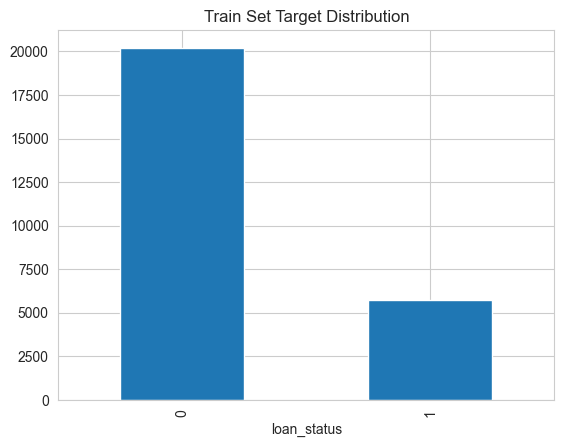

In [59]:

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [60]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40418, 3) (40418,) (6484, 3) (6484,)


Check Train Set Target distribution after SMOTE

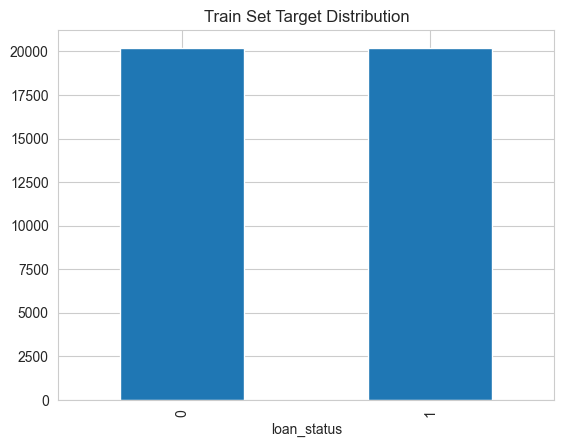

In [61]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Next we will conduct another grid search using the most suitable model from the last section and its best hyperparameter configuration.

Model from last grid search

In [ ]:
models_search 

{'RandomForestClassifier': RandomForestClassifier(random_state=0)}

And the best parameters from the last grid search 

In [62]:
best_parameters

{'model__n_estimators': 1000,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 3,
 'model__max_features': 'sqrt',
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__class_weight': None}

Save best hyperparameter values as a list

In [63]:
params_search = {'RandomForestClassifier':  {
    'model__n_estimators': [1000],
    'model__min_samples_split': [5],
    'model__min_samples_leaf': [3],
    'model__max_features': ['sqrt'],
    'model__max_depth': [6],
    'model__criterion': ['gini'],
    'model__class_weight': [None]
    }
}
params_search

{'RandomForestClassifier': {'model__n_estimators': [1000],
  'model__min_samples_split': [5],
  'model__min_samples_leaf': [3],
  'model__max_features': ['sqrt'],
  'model__max_depth': [6],
  'model__criterion': ['gini'],
  'model__class_weight': [None]}}

GridSearch CV

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
           scoring = make_scorer(hybrid_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

The summary performance of the reduced-feature pipeline is 0.79, slightly lower than the previous 0.80.

This difference is expected because SMOTE resampling was applied using only the three selected features, whereas previously all variables were used. The resulting training set is therefore slightly different, leading to a small change in pipeline performance.

Overall, the pipeline remains robust, and we consider this our best ML pipeline for deployment.

In [47]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__class_weight,model__criterion,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.780573,0.79712,0.811811,0.011091,None,gini,6,sqrt,3,5,1000


Define the best clf pipeline

In [64]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=1000,
                                        random_state=0))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['person_income', 'loan_int_rate', 'loan_amnt']


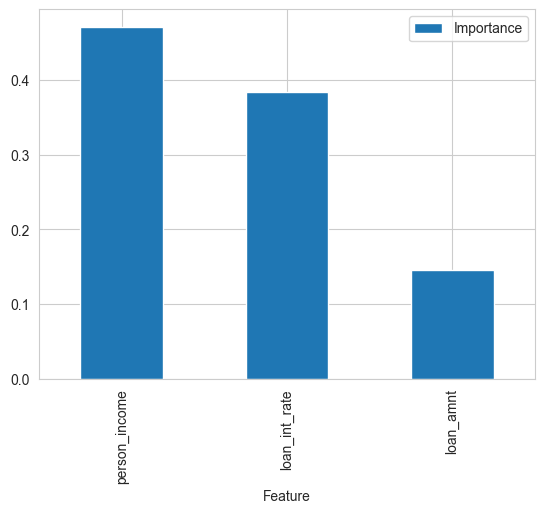

In [ ]:
# We don't have feature selection,
# so the best features are the columns from the train set.
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

* The features have the same relevance as before

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross check with the metrics defined in the ML business case
- Recall for default ≥ 0.75 – to minimize false negatives (high-risk borrowers predicted as safe)
- F1 score ≥ 0.60 – ensures a balance between recall and precision

Metrics should be met both on training and test sets.

In [50]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                 16355               3854
Actual Default                     4039              16170


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.80      0.81      0.81     20209
     Default       0.81      0.80      0.80     20209

    accuracy                           0.80     40418
   macro avg       0.80      0.80      0.80     40418
weighted avg       0.80      0.80      0.80     40418
 

#### Test Set ####

---  Confusion Matrix  ---
                  Prediction No Default Prediction Default
Actual No Default                  4088               1030
Actual Default                      300               1066


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.93      0.80      0.86      5118
     Default       0.51      0.78      0.62 

The model achieves a recall of 0.80 on the training set and 0.78 on the test set, both above the business threshold of 0.75, ensuring that high-risk borrowers are correctly identified. 

The F1 score is 0.80 on training and 0.62 on testing, showing a drop due to lower precision on unseen data but still above the minimum requirement of 0.60.

Performance is reasonably consistent between training and test sets, and the high recall confirms the model’s effectiveness at capturing defaulters, fulfilling the key business objectives.

* Overall the results are very similar to the results we previously had for the pipeline with all features

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [66]:
# First, we set a version tag, which will be the folder name. It's appropriate since it's a form
# of version control.
version = 'v2'
file_path = f'outputs/ml_pipeline/predict_default/{version}'

# create a folder to store the files.
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

We will save the train and test set since we need them to evaluate the model in the dashboard.

Note that the data cleaning and feature engineering
pipeline have transformed the features. Also SMOTE has already been applied to the train set.

In [67]:
print(X_train.shape)
X_train.head()

(40418, 3)


,person_income,loan_int_rate,loan_amnt
0,10.473450,9.32,100.000000
1,11.002100,6.91,83.666003
2,10.727663,10.99,44.721360
3,11.849398,7.88,109.544512
4,9.852194,7.88,59.160798


In [68]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [69]:
y_train

0        0
1        0
2        0
3        0
4        1
        ..
40413    1
40414    1
40415    1
40416    1
40417    1
Name: loan_status, Length: 40418, dtype: int64

In [70]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [71]:
print(X_test.shape)
X_test.head()

(6484, 3)


,person_income,loan_int_rate,loan_amnt
21641,10.819778,13.49,77.459667
74,11.350407,7.49,167.332005
416,11.034954,7.90,154.919334
9369,11.025816,10.99,50.000000
6814,11.082143,10.99,77.459667


In [72]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [73]:
y_test

21641    0
74       1
416      1
9369     0
6814     0
        ..
29306    1
21414    0
7349     0
21283    0
12696    0
Name: loan_status, Length: 6484, dtype: int64

In [74]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [75]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['loan_int_rate'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_income', 'loan_amnt',
                                       'loan_int_rate'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('power_transform', PowerTransformer(variables=['loan_amnt']))])

In [76]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_default/v2/clf_pipeline_data_cleaning_feat_eng.pkl']

Pipeline responsible for Feature Scaling, and Model

In [77]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=3,
                                        min_samples_split=5, n_estimators=1000,
                                        random_state=0))])

In [78]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_default/v2/clf_pipeline_model.pkl']

## Feature Importance plot

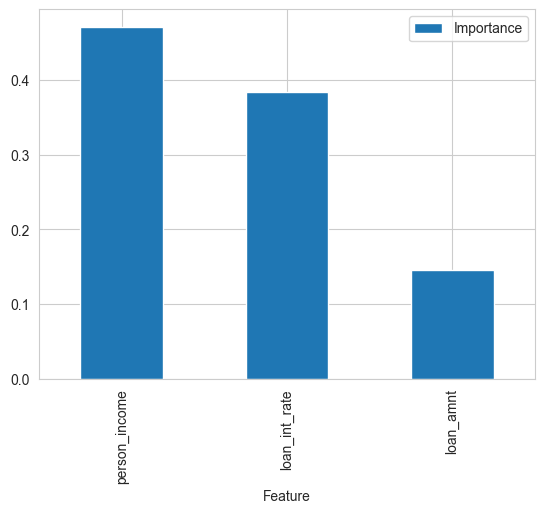

In [79]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

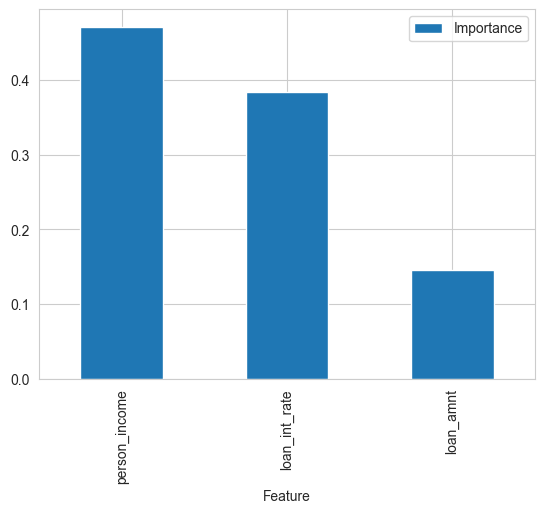

In [80]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---

# Conclusions and Next Steps

* Fill in conclusions and next steps TODO